# Modelo XGBoost

In [1]:
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
import os

In [2]:
ruta_carpeta_actual = os.getcwd()
ruta_carpeta_raiz = os.path.dirname(ruta_carpeta_actual)
csv_path  = os.path.join(ruta_carpeta_raiz, "dataset", "PuntosMuestra_CR_2023.csv")
df = pd.read_csv(csv_path)

In [3]:
# Contar instancias por categoría (en todo el dataset)
conteo_total = df["CATEGORIA"].value_counts().sort_index()
print("Instancias por categoría (dataset completo):\n", conteo_total)

Instancias por categoría (dataset completo):
 CATEGORIA
1      8197
2         2
3     15227
4      1118
6      1181
7      1373
10     2103
Name: count, dtype: int64


## Limpieza

In [4]:
# Eliminar CATEGORIA = 2
df_filtrado = df[df['CATEGORIA'] != 2].copy()

# Remapear categorías a consecutivas 0..K-1
clases_unicas = sorted(df_filtrado["CATEGORIA"].unique())
mapa = {old: new for new, old in enumerate(clases_unicas)}
df_filtrado["CATEGORIA"] = df_filtrado["CATEGORIA"].map(mapa)

y = df_filtrado["CATEGORIA"]
X = df_filtrado.drop(columns=["CATEGORIA", "lon", "lat", "year"])

## Definir modelo XGBoost

### Division de datos

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [6]:
# Conteo en train
conteo_train = y_train.value_counts().sort_index()
print("Instancias por categoría en TRAIN:\n", conteo_train)

# Conteo en test
conteo_test = y_test.value_counts().sort_index()
print("\nInstancias por categoría en TEST:\n", conteo_test)

Instancias por categoría en TRAIN:
 CATEGORIA
0     5738
1    10659
2      782
3      827
4      961
5     1472
Name: count, dtype: int64

Instancias por categoría en TEST:
 CATEGORIA
0    2459
1    4568
2     336
3     354
4     412
5     631
Name: count, dtype: int64


### Balancear los datos
Las categorias 3 y 1 son demasiadas a comparación de las otras, por lo que es necesario balancear las muestras

In [7]:
from imblearn.under_sampling import RandomUnderSampler

# Usar metodo submuestreo UNDERSAMPLING
rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)

In [8]:
# Conteo en train
conteo_train = y_train.value_counts().sort_index()
print("Instancias por categoría en TRAIN:\n", conteo_train)

# Conteo en test
conteo_test = y_test.value_counts().sort_index()
print("\nInstancias por categoría en TEST:\n", conteo_test)

Instancias por categoría en TRAIN:
 CATEGORIA
0    782
1    782
2    782
3    782
4    782
5    782
Name: count, dtype: int64

Instancias por categoría en TEST:
 CATEGORIA
0    2459
1    4568
2     336
3     354
4     412
5     631
Name: count, dtype: int64


### Definir XGBoost utilizado

In [9]:
use_gpu = False  # True si hay CUDA y xgboost con soporte GPU

xgb = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softprob",  # multi-clase
    eval_metric="mlogloss",
    tree_method="gpu_hist" if use_gpu else "hist",
    device="cuda" if use_gpu else "cpu",
    n_jobs=-1,
    random_state=42
)

### Entrenamiento

In [10]:
t0 = time.perf_counter()
xgb.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],       # útil para early_stopping
    verbose=False
)
t1 = time.perf_counter()
fit_s = t1 - t0
print(f"⏱ XGBoost – entrenamiento: {fit_s:.2f}s")

# TEST
t0 = time.perf_counter()
y_pred = xgb.predict(X_test)
t1 = time.perf_counter()
pred_s = t1 - t0
print(f"⏱ XGBoost – predicción: {pred_s:.3f}s  ({pred_s/len(y_test)*1000:.2f} ms/muestra)")


⏱ XGBoost – entrenamiento: 6.54s
⏱ XGBoost – predicción: 0.126s  (0.01 ms/muestra)


## Metricas

In [11]:
oa  = accuracy_score(y_test, y_pred)
f1m = f1_score(y_test, y_pred, average="macro")
cm  = confusion_matrix(y_test, y_pred, labels=np.sort(y.unique()))

print(f"OA: {oa:.3f}")
print(f"F1 macro: {f1m:.3f}")
print("Etiquetas (orden en matriz):", np.sort(y.unique()).tolist())
print("Matriz de confusión:\n", cm)
print("\nReporte por clase:\n", classification_report(y_test, y_pred, digits=3))

OA: 0.840
F1 macro: 0.788
Etiquetas (orden en matriz): [0, 1, 2, 3, 4, 5]
Matriz de confusión:
 [[2218  164   12   16   23   26]
 [ 334 3773    4   21   88  348]
 [   6    1  317   12    0    0]
 [   5    2   10  284   29   24]
 [  17   16    0   16  319   44]
 [  24   48    0   35   74  450]]

Reporte por clase:
               precision    recall  f1-score   support

           0      0.852     0.902     0.876      2459
           1      0.942     0.826     0.880      4568
           2      0.924     0.943     0.934       336
           3      0.740     0.802     0.770       354
           4      0.598     0.774     0.675       412
           5      0.504     0.713     0.591       631

    accuracy                          0.840      8760
   macro avg      0.760     0.827     0.788      8760
weighted avg      0.860     0.840     0.846      8760



### Matriz de confusion

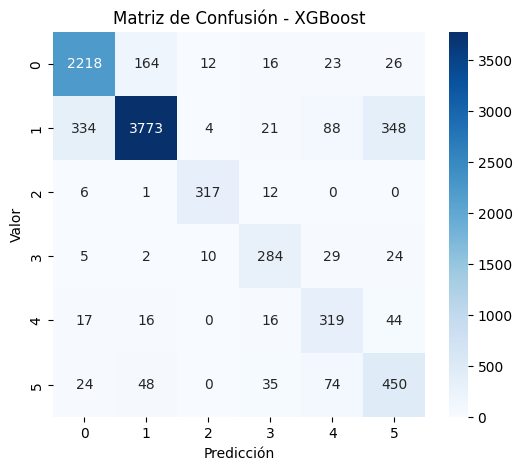

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- calcular matriz de confusión con los últimos resultados ---
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.xlabel("Predicción")
plt.ylabel("Valor")
plt.title("Matriz de Confusión - XGBoost")
plt.show()

# Registrar informacion

In [ ]:
import sys
sys.path.append("..")
import importlib, utils_log
importlib.reload(utils_log)
from utils_log import log_row

carpeta_actual = ruta_carpeta_actual.split("\\")[-1]
dataset_utilizado = csv_path.split("\\")[-1]

log_row(
  script="20250901_PruebasEntrenamientoXGB.ipynb",
  algoritmo="XGBoost",
  dataset=dataset_utilizado,
  clases_removidas=[2],
  seed=42,
  n_train=len(y_train), n_test=len(y_test),
  n_features=X.shape[1], num_classes=len(sorted(y.unique())),
  fit_seconds=fit_s,
  pred_seconds=pred_s,
  ms_per_sample=(pred_s/len(y_test))*1000,
  OA=oa, F1_macro=f1m,
  carpeta=carpeta_actual
)